Part 1

In [1]:
import os
import numpy as np
import scipy as sp
import random
import matplotlib.pyplot as plt
import IPython
import sounddevice as sd
import soundfile as sf

Step 1.0

In [2]:
music_stereo, f1 = sf.read('music.wav')
music_mono = music_stereo[:,0]/2 + music_stereo[:,1]/2 # Convert to mono format

#print(f1)

music = music_mono / np.amax(abs(music_mono)) # Music normalized 

N = 512 # frame length
hann = np.hanning(N)
                             
size = np.size(music)
frames = []                             

#print(size//512)
#print(size/512)

i = 0 
while i <= (size - 512):
    frames.append(music[i:i+512]*hann)   # List of frames of 512 specimens windowed with hanning
    i = i + 512

#print(len(frames))

Zeros = np.zeros(512 - (size - i))
frames.append(np.concatenate((music[i:], Zeros), axis = None)*hann)

#print(np.size(frames[-1]))
#print(frames[-1])

Step 1.1

Text(0.5, 1.0, 'Power Spectrum of 3rd frame')

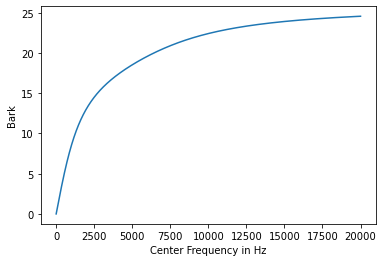

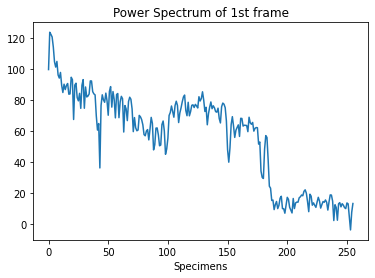

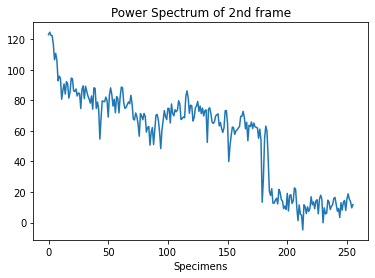

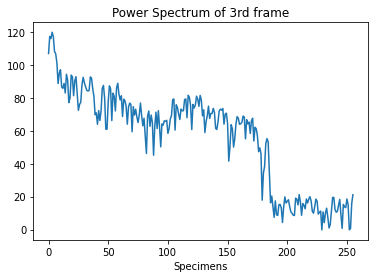

In [3]:
%matplotlib inline
f = np.arange(0,20000,1)
b = 13* np.arctan(0.00076*f) + 3.5*np.arctan((f/7500)**2) # bark scale

plt.figure(1)
plt.plot(f,b)
plt.xlabel('Center Frequency in Hz')
plt.ylabel('Bark')

Power_Spectrum = []
PN = 90.302

for frame in frames:
    p = 20*np.log10(abs(np.fft.fft(frame))) + PN
    p_cut = p[:256]
    Power_Spectrum.append(p_cut)

plt.figure(2)
k = np.arange(0,256,1)
plt.plot(k,Power_Spectrum[1])
plt.xlabel('Specimens')
plt.title('Power Spectrum of 1st frame')

plt.figure(3)
plt.plot(k,Power_Spectrum[2])
plt.xlabel('Specimens')
plt.title('Power Spectrum of 2nd frame')

plt.figure(4)
plt.plot(k,Power_Spectrum[3])
plt.xlabel('Specimens')
plt.title('Power Spectrum of 3rd frame')    

Step 1.2

In [4]:
def St(k, power_spectrum):
    bool = True 
    i = 2
    if k <= 2:
        bool = False
    elif 2 < k < 63 :
        predicate_1 = power_spectrum[k] > power_spectrum[k - 1] and power_spectrum[k] > power_spectrum[k + 1]
        bool = predicate_1 and bool
        while i <= 2:
            predicate = power_spectrum[k] > (power_spectrum[k - i] + 7) and power_spectrum[k] > (power_spectrum[k + i] + 7)
            bool = predicate and bool
            i = i + 1
    elif 63 <= k < 127 :
        predicate_1 = power_spectrum[k] > power_spectrum[k - 1] and power_spectrum[k] > power_spectrum[k + 1]
        bool = predicate_1 and bool
        while i <= 3:
            predicate = power_spectrum[k] > (power_spectrum[k - i] + 7) and power_spectrum[k] > (power_spectrum[k + i] + 7)
            bool = predicate and bool
            i = i + 1
    elif 127 <= k <= 250 :
        predicate_1 = power_spectrum[k] > power_spectrum[k - 1] and power_spectrum[k] > power_spectrum[k + 1]
        bool = predicate_1 and bool
        while i <= 6:
            predicate = power_spectrum[k] > (power_spectrum[k - i] + 7) and power_spectrum[k] > (power_spectrum[k + i] + 7)
            bool = predicate and bool
            i = i + 1
    return bool

Masks = []
for power_spectrum in Power_Spectrum:
    Masks.append(np.zeros(256))
    for k in range(250):
        if(St(k, power_spectrum)):
            Masks[-1][k] = 10*np.log10(10**(0.1*power_spectrum[k-1]) + 10**(0.1*power_spectrum[k]) + 10**(0.1*power_spectrum[k+1]))


Noise_masks = np.load('P_NM.npy')
#print(Noise_masks)

Step 1.3

In [5]:
tone_masks_cut = np.load('P_TMc.npy')
noise_masks_cut = np.load('P_NMc.npy')

print(type(tone_masks_cut))
print(tone_masks_cut.shape)

# for i in range(256):
#     for j in range(1179): 
#         if(tone_masks_cut[i][j]>0): print(tone_masks_cut[i][j], i, j)
# print(tone_masks_cut[:][2:3])
# A = np.zeros((3,3))
# A[2][1] = 1;
# print(A[:,1])
# print(A)


<class 'numpy.ndarray'>
(256, 1179)


Step 1.4

In [9]:
print("test")

test


In [175]:
fs = 44100

def SF(i, j, half_frame): #we assume (b_i - b_j)<=12
    f_i = i*fs/N;
    f_j = j*fs/N;
    b_i = 13*np.arctan(0.00076*f_i) + 3.5*np.arctan((f_i/7500)**2) # bark scale
    b_j = 13*np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale
    delta = b_i - b_j
    if(delta>=-3 and delta<-1): return (17*delta - 0.4*half_frame[j] + 11)
    elif(delta<0): return ((0.4*half_frame[j] + 6)*delta)
    elif(delta<1): return -17*delta
    else: return ((0.15*half_frame[j] - 17)*delta - 0.15*half_frame[j])

def T_tm(i,j, half_frame):
    f_i = i*fs/N;
    f_j = j*fs/N;
    b_i = 13* np.arctan(0.00076*f_i) + 3.5*np.arctan((f_i/7500)**2) # bark scale
    b_j = 13* np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale
    delta = b_i - b_j
    if(delta>12): return 0
    else: return (half_frame[j] - 0.175*b_j + SF(i,j,half_frame) - 6.025)
    
def T_nm(i,j, half_frame):
    f_i = i*fs/N;
    f_j = j*fs/N;
    b_i = 13* np.arctan(0.00076*f_i) + 3.5*np.arctan((f_i/7500)**2) # bark scale
    b_j = 13* np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale
    delta = b_i - b_j
    if(delta>12): return 0
    else: return (half_frame[j] - 0.175*b_j + SF(i,j,half_frame) - 2.025)
    

Thresholds_full = []
for counter in range(1179):
    if(counter%100==0):print(counter)    #for debugging
    if(counter==1178): print("done")
    half_frame_tone = tone_masks_cut[:,counter]
    half_frame_noise = noise_masks_cut[:,counter]
    j_noise = []
    j_tone = []
    Thresholds_per_half_frame = np.zeros((256,256), dtype=object)
    for j in range(256):
        if(half_frame_tone[j]>0):
            j_tone.append(j)
        if(half_frame_noise[j]>0):
            j_noise.append(j)
#             print(j)
    for j in j_noise:
        for i in range(256):
            T_noise = T_nm(i,j,half_frame_noise)
            Thresholds_per_half_frame[i][j] = (T_noise, 0)
    for j in j_tone:
        for i in range(256):
            T_tone = T_tm(i,j,half_frame_tone)
            if((isinstance(Thresholds_per_half_frame[i][j], int)==0)): Thresholds_per_half_frame[i][j] = (Thresholds_per_half_frame[i][j][0], T_tone)
            else: Thresholds_per_half_frame[i][j] = (0, T_tone)
    Thresholds_full.append(Thresholds_per_half_frame)
            

0
100
200
300
400
500
600
700
800
900
1000
1100
done


In [176]:
print(Thresholds_full[1178])

[[(111.43246060387159, 0) (67.10271243815623, 0) (46.58405816112532, 0)
  ... 0 0 0]
 [(96.97835709902104, 0) (110.53656458419565, 0) (66.2608997624475, 0)
  ... 0 0 0]
 [(94.44538607593555, 0) (96.18917734843271, 0) (108.85690545896102, 0)
  ... 0 0 0]
 ...
 [(0, 0) (0, 0) (0, 0) ... 0 0 0]
 [(0, 0) (0, 0) (0, 0) ... 0 0 0]
 [(0, 0) (0, 0) (0, 0) ... 0 0 0]]


In [177]:
print(Thresholds_full[1])

[[(121.89061402971403, 0) (76.05030932323189, 0) (54.74032845207969, 0)
  ... 0 0 0]
 [(107.43651052486348, 0) (124.09551313417278, 0) (75.26561815859218, 0)
  ... 0 0 0]
 [(105.99255539135734, 0) (109.74812589840985, 0) (122.4506892772183, 0)
  ... 0 0 0]
 ...
 [(0, 0) (0, 0) (0, 0) ... 0 0 0]
 [(0, 0) (0, 0) (0, 0) ... 0 0 0]
 [(0, 0) (0, 0) (0, 0) ... 0 0 0]]


Step 1.5

In [101]:
fs = 44100
N = 512

def T_q(i):   
    f = i*fs/N;
    return 3.64*((f/1000)**(-0.8)) - 6.5*np.exp(-0.6*((f/1000 - 3.3)**2)) + (10**(-3))*((f/1000)**4)

In [102]:
def T_g(i, pinakas):
    sum_tone = 0
    sum_noise = 0
    for j in range(256):
        if((isinstance(pinakas[i][j], int)==0)):
            T_noise = pinakas[i][j][0]
            T_tone = pinakas[i][j][1]
            if(T_noise>0): sum_noise += 10**(0.1*T_noise)
            if(T_tone>0): sum_tone += 10**(0.1*T_tone)
    return 10*np.log10(10**(0.1*T_q(i)) + sum_noise + sum_tone)
            

In [118]:
# pinakas = Thresholds_full[100]

# print(T_g(45, pinakas))

In [147]:
Total_Thresholds = []

for counter in range(1179):
    Total_Thresholds_list = []
    if(counter%100==0):print(counter)    #for debugging
    pinakas = Thresholds_full[counter]
    i = 1
    while(i<256):
#         if(counter==1): print(i)
        total = T_g(i, pinakas)
        Total_Thresholds_list.append(total)
        i += 1
    Total_Thresholds.append(Total_Thresholds_list)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [157]:
# for i in range(1181):
#     print(Total_Thresholds[0][i])

deikths = 1
for i in range(255):
    if(Total_Thresholds[0][i]!=Total_Thresholds[100][i]): 
        deikths = 0
        break
print(deikths)        
#print(Total_Thresholds[1178])

1
